# Deep Convolutional GAN (DCGAN)

Generative Adversarial Networks, or GANs for short, are an approach to **Generative Modeling** using deep learning methods. Generative modeling is an unsupervised learning task in machine learning that involves automatically discovering and learning the regularities or patterns in input data in such a way that the model can be used to generate or output new examples that plausibly could have been drawn from the original dataset.

The GAN model architecture involves two sub-models: a generator model for generating new examples and a discriminator model for classifying whether generated examples are real, from the domain, or fake, generated by the generator model.
- **Generator:** Model that is used to generate new plausible examples from the problem domain.
- **Discriminator:** Model that is used to classify examples as real (from the domain) or fake (generated).

**Application of GANs:**
* Generate Examples for Image Datasets(i.e, medical data such as X-ray, MRI)
* Super Resolution
* Clothing Translation
* 3D Object Generation
* Text-to-Image Translation


Here is the implementation of a **Deep Convolutional GAN(DCGAN)** on A-Z dataset.
In this Notebook, we will see how to,
   * Load torchvision dataset
   * Create Generator network
   * Create Discriminator network
   * Train GAN
   * Evaluate GAN during training by plotting results of Generator

## Import Packages

In [44]:
import torch
from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

from torchvision.utils import make_grid

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [45]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import math
from torch.utils.data import DataLoader 

In [46]:
# Function to visualizing images from tensor

def show_tensor_images(tensor_img, num_img=25, size=(1, 28, 28)):
    tensor_img = (tensor_img + 1) / 2
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_img], nrow=5)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

DCGAN is a very successful and influential GAN model developed in 2015. Most GANs today are at least loosely based on the DCGAN architecture.

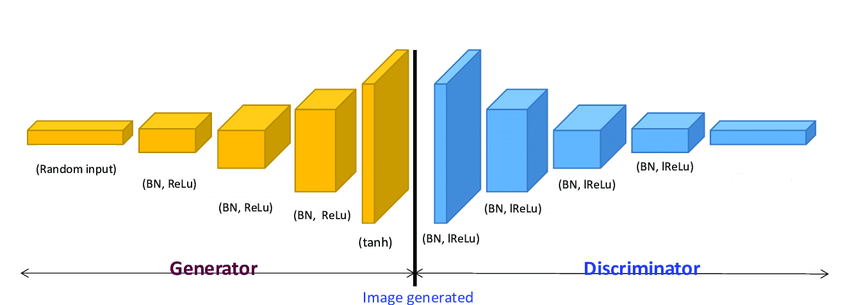

Here are the main features of DCGAN:
*   Use convolutions without any pooling layers
*   Use batchnorm in both the generator and the discriminator
*   Don't use fully connected hidden layers
*   Use ReLU activation in the generator for all layers except for the output, which uses a Tanh activation.
*   Use LeakyReLU activation in the discriminator for all layers except for the output, which does not use an activation
*   Both Generator and Discriminator use 4 layers as 3 hidden layers and 1 output layer


## Load data

In [47]:
import numpy as np
import math
#loader function
class data_load:
    def __init__(self,url,mode='train',trans=None):
        data=np.loadtxt(url,delimiter=',',skiprows=1,dtype=np.float32)
        A=data[:,1:][data[:,0]==0]
        B=data[:,1:][data[:,0]==1]
        A=A.reshape(A.shape[0],28,28)/255
        B=B.reshape(B.shape[0],28,28)/255
        
        if A.shape > B.shape:
            limit= B.shape[0]
        else:
            limit=A.shape[0]
        index=int(math.floor(limit*(4/5)))
        if mode=='train': 
            self.A=A[:index,:]
            self.B=B[:index,:]
        elif mode=='test':
            self.A=A[index:limit,:]
            self.B=B[index:limit,:]
        
        
        self.len=self.A.shape[0]    
        self.trans=trans
        
    def __len__(self):
        return self.len
    
    def __getitem__(self,index):
        A=self.A[index]
        B=self.B[index]
        if self.trans is not None:
            A=self.trans(A)
            B=self.trans(B)
        return A,B

In [48]:
# More transforms can be added
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_loader = DataLoader(
data_load("/kaggle/input/az-handwritten-alphabets-in-csv-format/A_Z Handwritten Data.csv",
trans=transform),
batch_size=20,
shuffle=True)

Shape of loading one batch: torch.Size([20, 1, 28, 28])
Total no. of batches present in trainloader: 347


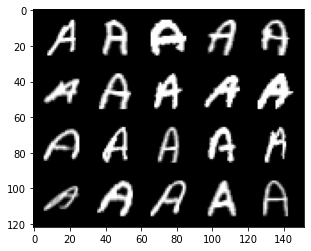

In [49]:
# Display images from train_loader

dataiter = iter(train_loader)
images,labels = dataiter.next()
print('Shape of loading one batch:', images.shape)
print('Total no. of batches present in trainloader:', len(train_loader))

show_tensor_images(images)

## Generator

In [50]:
class Generator(nn.Module):

    def __init__(self, z_dim=10, img_channel=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        self.gen = nn.Sequential(
            self.gen_block(z_dim, hidden_dim * 4),
            self.gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.gen_block(hidden_dim * 2, hidden_dim),
            self.gen_block(hidden_dim, img_channel, kernel_size=4, final_layer=True),
        )

    def gen_block(self, input_channel, output_channel, kernel_size=3, stride=2, final_layer=False):
        '''
        Function that return a basic Sequential block for the Generator of DCGAN, corresponding to
            - Transposed Convolution
            - Batchnorm (except for in the last layer)
            - Activation
        '''
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channel, output_channel, kernel_size, stride),
                nn.BatchNorm2d(output_channel),
                nn.ReLU(inplace=True)
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channel, output_channel, kernel_size, stride),
                nn.Tanh()
            )

    def forward(self, x):
        x = x.view(len(x), self.z_dim, 1, 1)      # change the shape: (batch_size, channels=z_dim, width=1, height=1)
        return self.gen(x)


## Discriminator

In [51]:
class Discriminator(nn.Module):

    def __init__(self, img_channel=1, hidden_dim=16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.disc_block(img_channel, hidden_dim, kernel_size=4),
            self.disc_block(hidden_dim, hidden_dim * 2),
            self.disc_block(hidden_dim * 2, hidden_dim * 4, kernel_size=4, stride=1),
            self.disc_block(hidden_dim * 4, 1, final_layer=True),
        )

    def disc_block(self, input_channel, output_channel, kernel_size=3, stride=2, final_layer=False):
        '''
        Function that return a basic Sequential block for the Discriminator of DCGAN, corresponding to
            - Convolution
            - Batchnorm (except for in the last layer)
            - LeakyReLU activation with 0.2 slope of the leak
        '''
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channel, output_channel, kernel_size, stride),
                nn.BatchNorm2d(output_channel),
                nn.LeakyReLU(0.2, inplace=True)
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channel, output_channel, kernel_size, stride)
            )
  
    def forward(self, image):
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)    # returns 1-dimension tensor representing fake/real

## Initialize Generator and Discriminator

In [52]:
# required parameters for training

z_dim = 64
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [53]:
G = Generator(z_dim).to(device)
D = Discriminator().to(device)

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

G = G.apply(weights_init)
D = D.apply(weights_init)

## Define loss and Optimizer 

In [54]:
beta_1 = 0.5         # parameters control the optimizer's momentum
beta_2 = 0.999       # parameters control the optimizer's momentum

G_opt = torch.optim.Adam(G.parameters(),lr=0.0002, betas=(beta_1, beta_2))
D_opt = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(beta_1, beta_2))

# 'BinaryCrossEntropy Loss' is used to evaluate how well dicriminator and generator performs
def real_loss(disc_pred):
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(disc_pred, torch.ones_like(disc_pred))
    return loss

def fake_loss(disc_pred):
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(disc_pred, torch.zeros_like(disc_pred))
    return loss


## Training
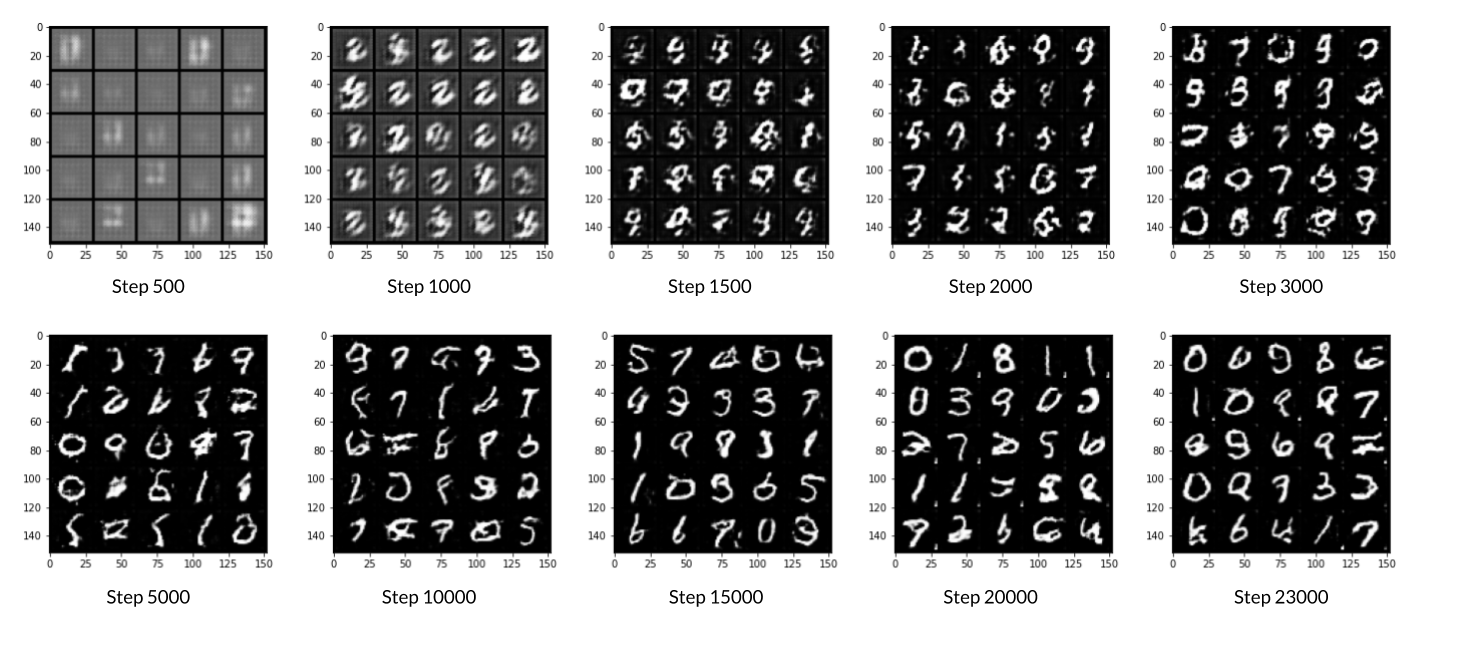

In [55]:
display_step = 1000      # how often to display/visualize the images

epochs = 40
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0

Step 14000: Generator loss: 7.1111415410041765, discriminator loss: 0.000984195237542737


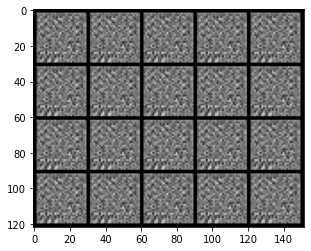

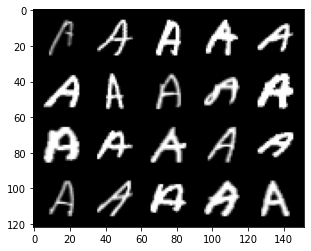

Step 15000: Generator loss: 7.931340070247648, discriminator loss: 0.00043162931494589434


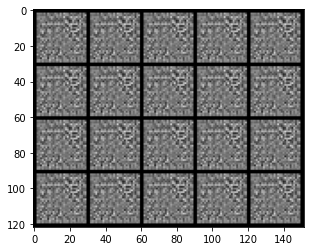

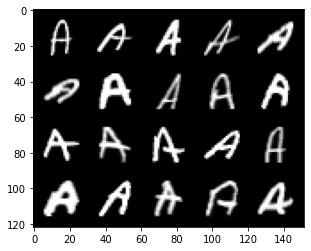

Step 16000: Generator loss: 8.646969936370844, discriminator loss: 0.00024116899715227158


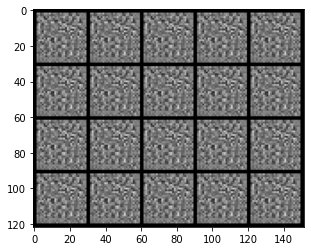

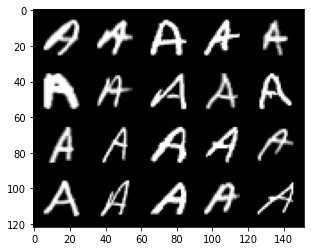

Step 17000: Generator loss: 9.228492882728569, discriminator loss: 0.0001244541417145229


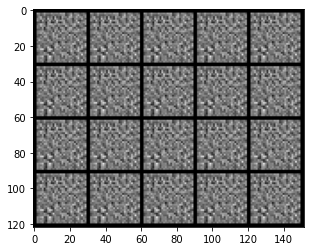

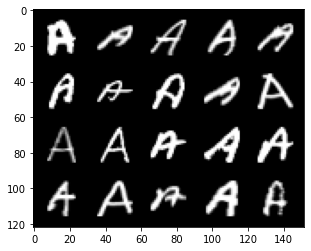

Step 18000: Generator loss: 9.602214835166945, discriminator loss: 8.33881729940912e-05


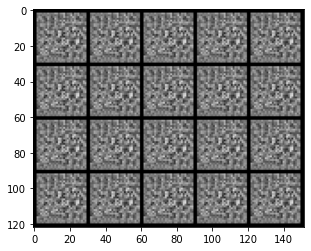

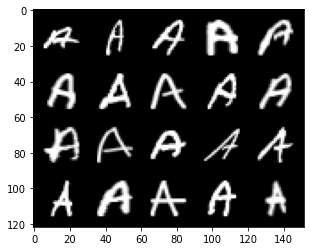

Step 19000: Generator loss: 7.4241960533261375, discriminator loss: 0.09877907924497399


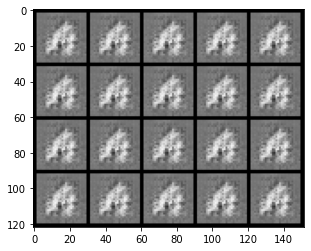

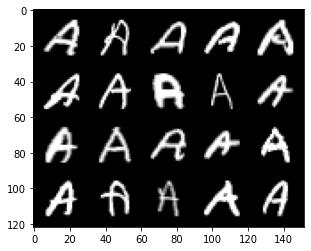

Step 20000: Generator loss: 3.1941376454532144, discriminator loss: 0.1720584749877452


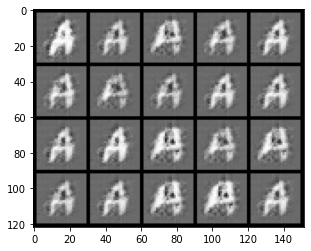

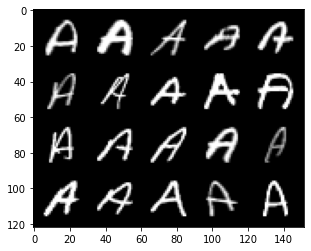

Step 21000: Generator loss: 2.93433874565363, discriminator loss: 0.16469670118019003


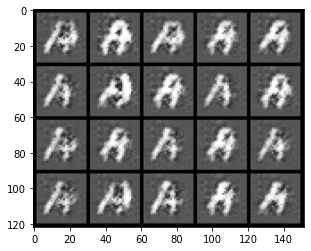

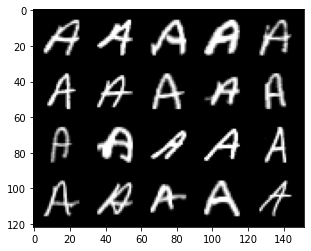

Step 22000: Generator loss: 2.809988862723113, discriminator loss: 0.18498458850011243


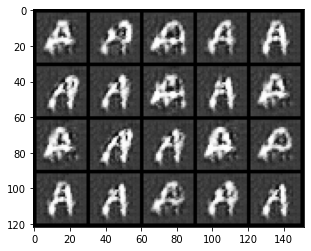

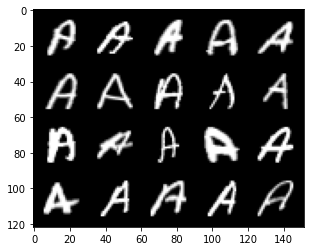

Step 23000: Generator loss: 2.4897532965242846, discriminator loss: 0.2157116588577627


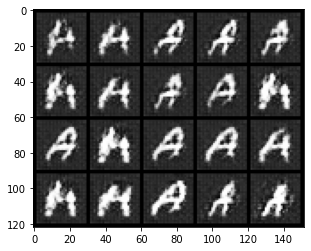

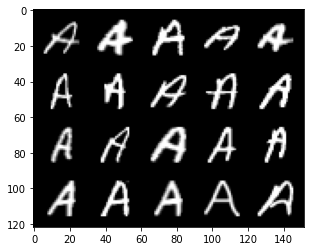

Step 24000: Generator loss: 2.3036880971789375, discriminator loss: 0.2674009797051551


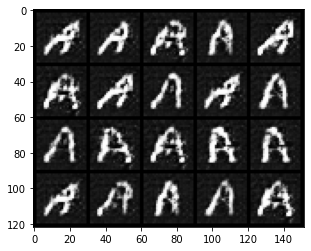

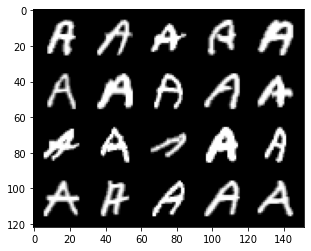

Step 25000: Generator loss: 2.0063267216235405, discriminator loss: 0.30867532291263367


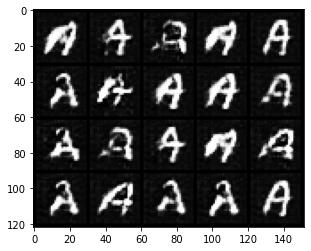

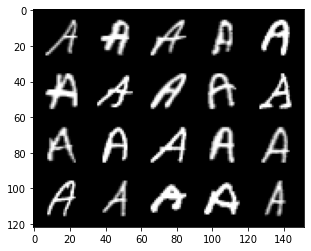

Step 26000: Generator loss: 1.952705163151029, discriminator loss: 0.3144051711857322


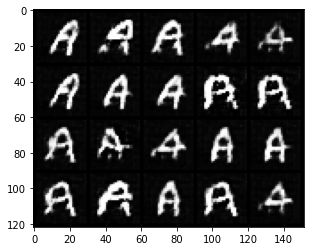

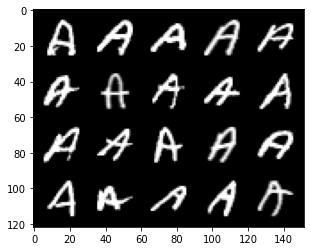

Step 27000: Generator loss: 1.8750347829163092, discriminator loss: 0.3390860400795938


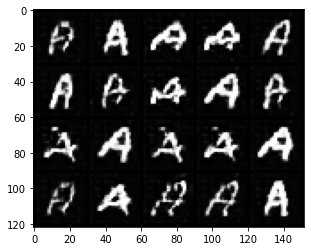

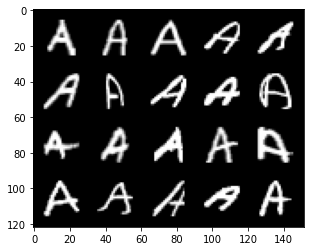

In [58]:
for epoch in range(epochs):
    for real_img,_ in tqdm(train_loader):

        batch_size = real_img.size(0)
        real_img = real_img.to(device)

        #  Update Discriminator  #
        D_opt.zero_grad()

        noise = torch.randn(batch_size, z_dim, device=device)
        fake_img = G(noise)
        D_pred = D(fake_img.detach())
        D_fake_loss = fake_loss(D_pred)

        D_pred = D(real_img)
        D_real_loss = real_loss(D_pred)
        D_loss = (D_fake_loss + D_real_loss) / 2
        mean_discriminator_loss += D_loss.item() / display_step    # Keep track of the average discriminator loss

        D_loss.backward(retain_graph=True)
        D_opt.step()

        # Update Generator #
        G_opt.zero_grad()
        noise = torch.randn(batch_size, z_dim, device=device)
        fake_img = G(noise)
        D_pred = D(fake_img)
        G_loss = real_loss(D_pred)
        mean_generator_loss += G_loss.item() / display_step     # Keep track of the average generator loss

        G_loss.backward()
        G_opt.step()

        # Visualization #
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            show_tensor_images(fake_img)
            show_tensor_images(real_img)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1


## Create more samples

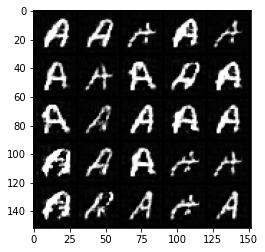

In [59]:
num_image = 30
noise = torch.randn(num_image, z_dim, device=device)
with torch.no_grad():
    fake_img = G(noise)
show_tensor_images(fake_img)